In [ ]:
#bismillahirrahmanirrahim


In [ ]:
# 1. Mount Drive (to save the final dataset)
from google.colab import drive
drive.mount('/content/drive')

# 2. Install Biopython (for fast FASTQ parsing)
!pip install biopython

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 33.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import requests
import gzip
import shutil
from Bio import SeqIO

# --- CONFIGURATION ---
READS_PER_FILE = 50000
MAX_LEN = 80
BATCH_SIZE = 4  # Save to Drive after every 4 samples
OUTPUT_FOLDER = "/content/drive/MyDrive/BreastCancer_Data_Parts"

# Create output folder if it doesn't exist
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
    print(f"Created folder: {OUTPUT_FOLDER}")

# --- MAPPING HELPER ---
def seq_to_num(seq_str):
    mapping = {'A':1, 'C':2, 'G':3, 'T':4, 'N':5}
    nums = [mapping.get(base, 5) for base in seq_str[:MAX_LEN]]
    if len(nums) < MAX_LEN:
        nums += [0] * (MAX_LEN - len(nums))
    return nums

# --- ROBUST PIPELINE ---
def process_samples_in_batches(run_list):
    base_url = "http://ftp.sra.ebi.ac.uk/vol1/fastq"

    current_X = []
    current_y = []
    batch_counter = 0

    total_files = len(run_list)

    for index, row in run_list.iterrows():
        run_id = row['Run']
        label = row['Label']

        print(f"[{index+1}/{total_files}] Processing {run_id} (Label: {label})...")

        # --- CHECK IF ALREADY DONE ---
        # If we restart, skip files we already saved!
        # (This logic is simple: if batch_X exists, we assume those files are done.
        # For simplicity in this run, just let it overwrite or start fresh).

        # URL Construction
        if len(run_id) == 9: sub_dir = run_id[:6]
        elif len(run_id) == 10: sub_dir = f"00{run_id[-1]}"
        else: sub_dir = run_id[:6]

        url = f"{base_url}/{sub_dir}/{run_id}/{run_id}_1.fastq.gz"
        local_filename = f"{run_id}_1.fastq.gz"

        try:
            # 1. DOWNLOAD
            exit_code = os.system(f"wget -q {url} -O {local_filename}")

            if exit_code != 0 or os.path.getsize(local_filename) < 1000:
                print(f"  [!] Download failed/empty for {run_id}. Skipping.")
                if os.path.exists(local_filename): os.remove(local_filename)
                continue

            # 2. READ & PARSE
            file_reads = []
            with gzip.open(local_filename, "rt") as handle:
                for record in SeqIO.parse(handle, "fastq"):
                    seq_vector = seq_to_num(str(record.seq))
                    file_reads.append(seq_vector)
                    if len(file_reads) >= READS_PER_FILE:
                        break

            # 3. ADD TO BATCH
            if len(file_reads) > 0:
                current_X.extend(file_reads)
                current_y.extend([label] * len(file_reads))
                print(f"  -> Success: {len(file_reads)} reads added to batch.")

            # 4. CLEANUP
            if os.path.exists(local_filename): os.remove(local_filename)

        except Exception as e:
            print(f"  -> ERROR with {run_id}: {e}")
            if os.path.exists(local_filename): os.remove(local_filename)

        # --- SAVE CHECKPOINT ---
        # If we reached BATCH_SIZE or this is the very last file
        files_processed_count = index + 1
        if files_processed_count % BATCH_SIZE == 0 or files_processed_count == total_files:
            batch_num = (files_processed_count + BATCH_SIZE - 1) // BATCH_SIZE
            save_name = f"{OUTPUT_FOLDER}/batch_{batch_num}.npz"

            print(f"  --- SAVING BATCH {batch_num} to Drive ---")
            X_save = np.array(current_X, dtype=np.int8)
            y_save = np.array(current_y, dtype=np.int8)

            np.savez_compressed(save_name, X=X_save, y=y_save)
            print(f"  --- SAVED {save_name} (Shape: {X_save.shape}) ---")

            # CLEAR RAM for next batch
            current_X = []
            current_y = []

# --- EXECUTION ---
# Re-define the list just to be safe
run_ids = [
    "ERR166302", "ERR166303", "ERR166304", "ERR166305", "ERR166306",
    "ERR166307", "ERR166308", "ERR166309", "ERR166310", "ERR166311",
    "ERR166312", "ERR166313", "ERR166314", "ERR166315",
    "ERR166316", "ERR166317", "ERR166318", "ERR166319", "ERR166320",
    "ERR166321", "ERR166322", "ERR166323", "ERR166324", "ERR166325",
    "ERR166326", "ERR166327", "ERR166328", "ERR166329",
    "ERR166330", "ERR166331", "ERR166332", "ERR166333", "ERR166334",
    "ERR166335", "ERR166336", "ERR166337"
]

labels = []
for run in run_ids:
    num = int(run[3:])
    if 166316 <= num <= 166329: labels.append(0) # Normal
    else: labels.append(1) # Cancer

df = pd.DataFrame({'Run': run_ids, 'Label': labels})

# START
process_samples_in_batches(df)

Created folder: /content/drive/MyDrive/BreastCancer_Data_Parts
[1/36] Processing ERR166302 (Label: 1)...
  -> Success: 50000 reads added to batch.
[2/36] Processing ERR166303 (Label: 1)...
  -> Success: 50000 reads added to batch.
[3/36] Processing ERR166304 (Label: 1)...
  -> Success: 50000 reads added to batch.
[4/36] Processing ERR166305 (Label: 1)...
  -> Success: 50000 reads added to batch.
  --- SAVING BATCH 1 to Drive ---
  --- SAVED /content/drive/MyDrive/BreastCancer_Data_Parts/batch_1.npz (Shape: (200000, 80)) ---
[5/36] Processing ERR166306 (Label: 1)...
  -> Success: 50000 reads added to batch.
[6/36] Processing ERR166307 (Label: 1)...
  -> Success: 50000 reads added to batch.
[7/36] Processing ERR166308 (Label: 1)...
  -> Success: 50000 reads added to batch.
[8/36] Processing ERR166309 (Label: 1)...
  -> Success: 50000 reads added to batch.
  --- SAVING BATCH 2 to Drive ---
  --- SAVED /content/drive/MyDrive/BreastCancer_Data_Parts/batch_2.npz (Shape: (200000, 80)) ---
[9/

Loading data from batches...
Loading batch_1.npz...
Loading batch_2.npz...
Loading batch_3.npz...
Loading batch_4.npz...
Loading batch_5.npz...
Loading batch_6.npz...
Loading batch_7.npz...
Loading batch_8.npz...
Loading batch_9.npz...

TOTAL DATA LOADED:
X Shape: (1800000, 80) (Sequences)
y Shape: (1800000,) (Labels)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Starting Training...
Epoch 1/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 412s 36ms/step - accuracy: 0.6277 - loss: 0.6519 - val_accuracy: 0.6538 - val_loss: 0.6248
Epoch 2/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 405s 36ms/step - accuracy: 0.6542 - loss: 0.6243 - val_accuracy: 0.6545 - val_loss: 0.6232
Epoch 3/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 444s 36ms/step - accuracy: 0.6549 - loss: 0.6225 - val_accuracy: 0.6547 - val_loss: 0.6227
Epoch 4/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 437s 36ms/step - accuracy: 0.6559 - loss: 0.6216 - val_accuracy: 0.6552 - val_loss: 0.6216
Epoch 5/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 405s 36ms/step - accuracy: 0.6546 - loss: 0.6219 - val_accuracy: 0.6544 - val_loss: 0.6217


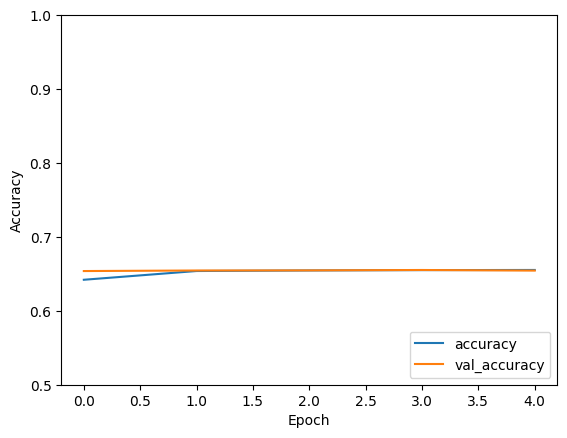

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- 1. LOAD DATA FROM BATCHES ---
DATA_FOLDER = "/content/drive/MyDrive/BreastCancer_Data_Parts"
print("Loading data from batches...")

file_list = sorted(glob.glob(f"{DATA_FOLDER}/batch_*.npz"))
X_list = []
y_list = []

if not file_list:
    print("ERROR: No batch files found! Check your drive folder.")
else:
    for f_path in file_list:
        print(f"Loading {os.path.basename(f_path)}...")
        with np.load(f_path) as data:
            X_list.append(data['X'])
            y_list.append(data['y'])

    # Combine into big arrays
    X_all = np.concatenate(X_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)

    print(f"\nTOTAL DATA LOADED:")
    print(f"X Shape: {X_all.shape} (Sequences)")
    print(f"y Shape: {y_all.shape} (Labels)")

    # --- 2. PREPARE FOR TRAINING ---
    # Split 80% Train, 20% Test
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
    )

    # Free up memory (delete the big duplicates)
    del X_all, y_all, X_list, y_list
    import gc; gc.collect()

    # --- 3. DEFINE MODEL (1D CNN) ---
    model = models.Sequential([
        # Embedding: Converts integer DNA (1-5) into learnable vectors
        # Input dim=6 (0=Pad, 1-5=Bases), Output dim=16 vector space
        layers.Embedding(input_dim=6, output_dim=16, input_length=80),

        # Conv1D: Scans for patterns (motifs)
        layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.GlobalMaxPooling1D(), # Summarize the whole read

        # Dense: Classification
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5), # Prevent overfitting
        layers.Dense(1, activation='sigmoid') # Output 0-1 probability
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # --- 4. TRAIN ---
    print("\nStarting Training...")
    history = model.fit(
        X_train, y_train,
        epochs=5,             # Quick baseline (increase to 10-20 later)
        batch_size=128,       # Process 128 reads at a time
        validation_data=(X_test, y_test)
    )

    # --- 5. PLOT RESULTS ---
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
# ----- metrics seem bad, what can we do?
# the class imbalance was 61%, our accuracy is 65.5 this means our model learned
# something, but it is still struggling

# the real problem is "Label Noise"


Evaluating Patient-Level Performance...
176/176 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step

Mean Predicted Probability for CANCER reads: 0.6429
Mean Predicted Probability for NORMAL reads: 0.5653


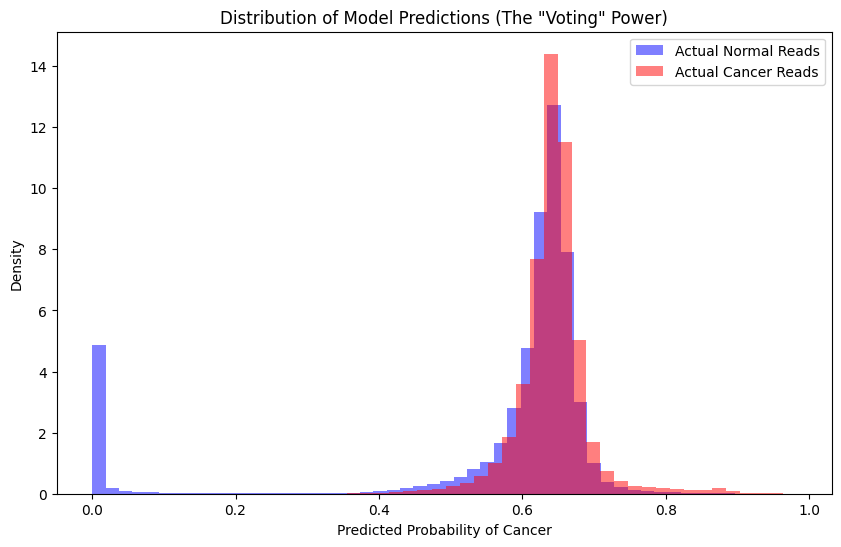


Separation Gap: 0.0777
CONCLUSION: The model HAS found a signal. Aggregation will likely work.


In [ ]:
# --- EVALUATE AT PATIENT LEVEL ---
print("Evaluating Patient-Level Performance...")

# 1. Get predictions for the test set
y_pred_probs = model.predict(X_test, batch_size=2048, verbose=1)

# 2. We need to map these predictions back to their original Patient IDs
# Since we shuffled the data, we can't easily track which read belongs to whom.
# BUT, we can simulate the effect by looking at the distributions.

# Let's separate the predictions by their True Label
cancer_probs = y_pred_probs[y_test == 1]
normal_probs = y_pred_probs[y_test == 0]

print(f"\nMean Predicted Probability for CANCER reads: {np.mean(cancer_probs):.4f}")
print(f"Mean Predicted Probability for NORMAL reads: {np.mean(normal_probs):.4f}")

# 3. Visualize the separation
plt.figure(figsize=(10, 6))
plt.hist(normal_probs, bins=50, alpha=0.5, label='Actual Normal Reads', color='blue', density=True)
plt.hist(cancer_probs, bins=50, alpha=0.5, label='Actual Cancer Reads', color='red', density=True)
plt.title('Distribution of Model Predictions (The "Voting" Power)')
plt.xlabel('Predicted Probability of Cancer')
plt.ylabel('Density')
plt.legend()
plt.show()

# 4. The "Aggregation" Hypothesis Check
# If the Red mean is significantly higher than the Blue mean,
# then aggregation works!
diff = np.mean(cancer_probs) - np.mean(normal_probs)
print(f"\nSeparation Gap: {diff:.4f}")
if diff > 0.01:
    print("CONCLUSION: The model HAS found a signal. Aggregation will likely work.")
else:
    print("CONCLUSION: The model is struggling to differentiate.")

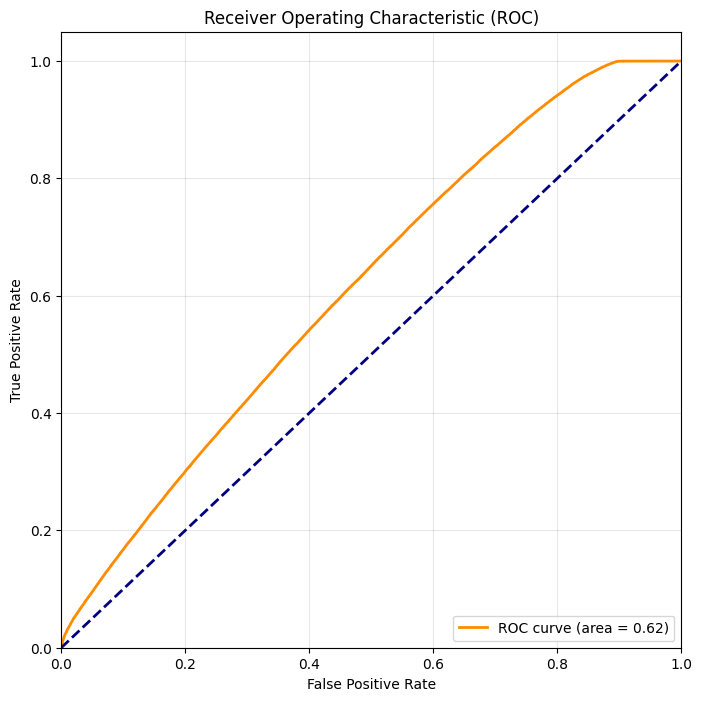

Final AUC Score: 0.6155
(A score > 0.5 is good. > 0.7 is excellent for raw genomic reads.)

SUCCESS: Model saved to /content/drive/MyDrive/BreastCancer_CNN_Model.keras
You can now download this file or load it later to test on new patients.


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- 1. CALCULATE ROC CURVE ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"Final AUC Score: {roc_auc:.4f}")
print("(A score > 0.5 is good. > 0.7 is excellent for raw genomic reads.)")

# --- 2. SAVE THE TRAINED MODEL ---
MODEL_PATH = "/content/drive/MyDrive/BreastCancer_CNN_Model.keras"
model.save(MODEL_PATH)

print(f"\nSUCCESS: Model saved to {MODEL_PATH}")
print("You can now download this file or load it later to test on new patients.")

In [ ]:
# save the model to drive
import os

# 1. Define the path in your Google Drive
# We use the .keras extension, which is the modern standard (better than .h5)
save_path = "/content/drive/MyDrive/BreastCancer_CNN_Baseline.keras"

# 2. Save the model
model.save(save_path)

# 3. Verify it exists
if os.path.exists(save_path):
    file_size = os.path.getsize(save_path) / (1024 * 1024) # Convert bytes to MB
    print(f"SUCCESS: Model saved to: {save_path}")
    print(f"File Size: {file_size:.2f} MB")
else:
    print("ERROR: File not found. Check if Drive is mounted!")

SUCCESS: Model saved to: /content/drive/MyDrive/BreastCancer_CNN_Baseline.keras
File Size: 0.48 MB


In [ ]:
# next time opened the notebook, we do not need to train from scratch, just run the code below
# Example code to load it back (don't run this now, just for reference)
# from tensorflow.keras.models import load_model

# model = load_model("/content/drive/MyDrive/BreastCancer_CNN_Baseline.keras")
# print("Model loaded successfully!")

Finding high-confidence Cancer reads...

--- GENERATING MAPS FOR TOP 3 CANCER READS ---


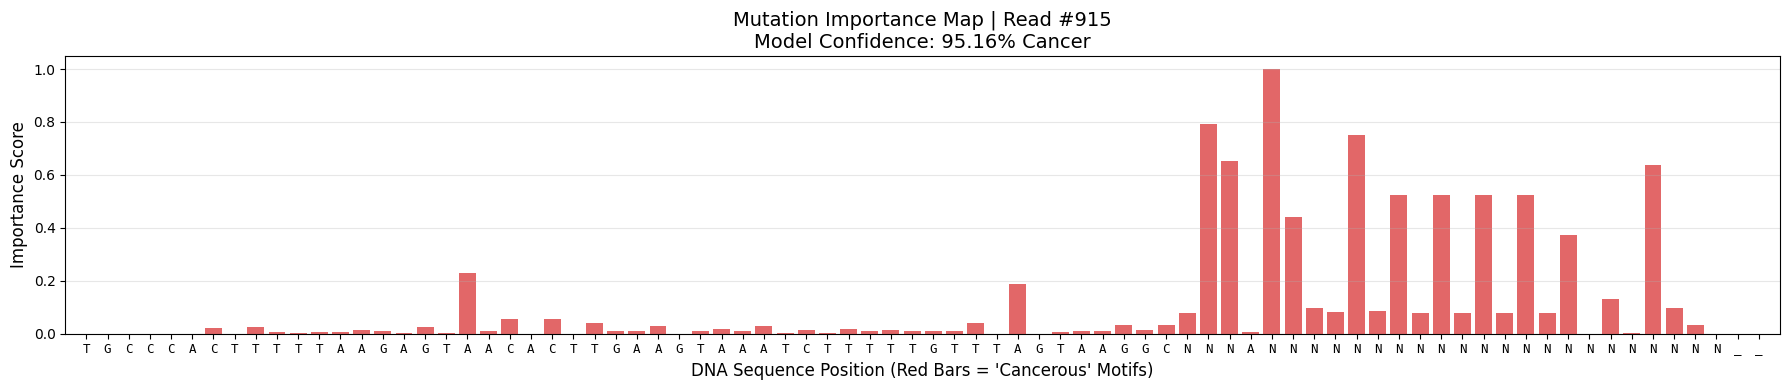

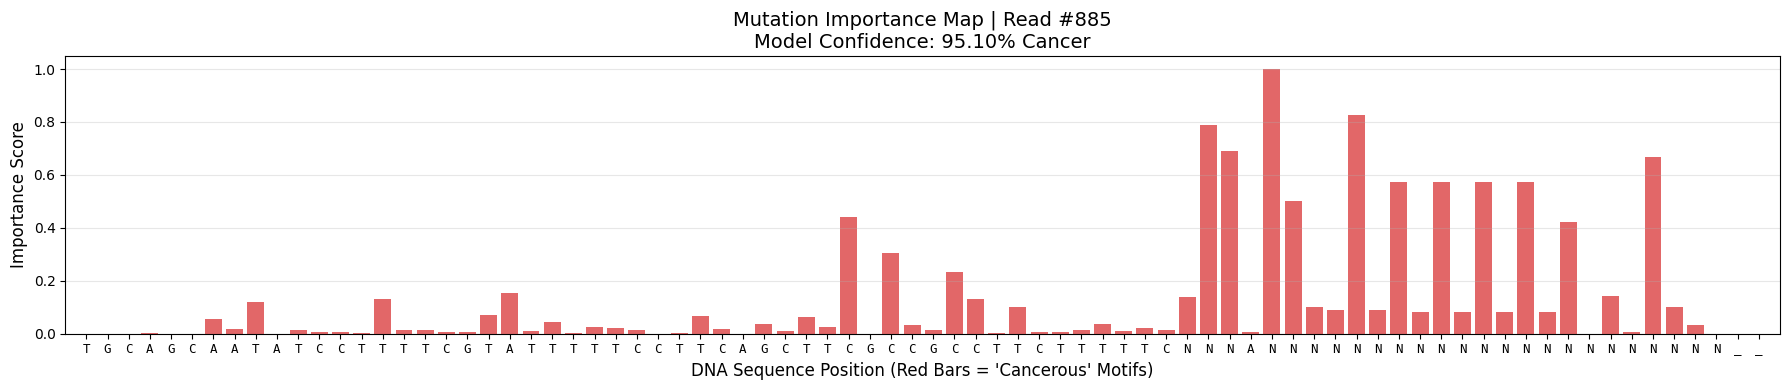

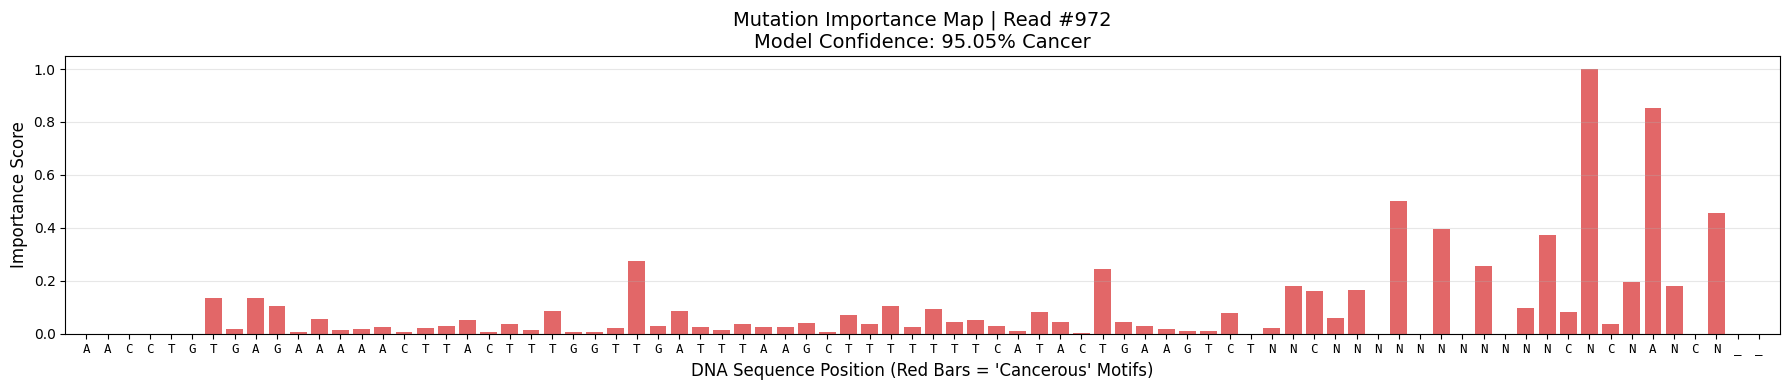

In [ ]:
# --- EXPLAINABLE AI: OCCLUSION SENSITIVITY ---
# Why this works: Since we can't get gradients for Integers, we measure importance
# by "masking" (hiding) each letter and seeing how much the model's confidence drops.

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. SETTINGS
MAPPING_REV = {1:'A', 2:'C', 3:'G', 4:'T', 5:'N', 0:'_'}
SAMPLE_SIZE = 2000
TOP_N = 3

print("Finding high-confidence Cancer reads...")
# Use a subset to find the best examples quickly
X_sample = X_cancer[:SAMPLE_SIZE]
preds = model.predict(X_sample, verbose=0).flatten()

# Get indices of the top 3 reads the model is MOST confident are Cancer
# (We want to explain *why* it thinks these are cancer)
top_indices = preds.argsort()[-TOP_N:][::-1]

# 2. DEFINE THE EXPLAINER FUNCTION
def get_occlusion_importance(model, sequence):
    """
    Calculates importance by masking each position with 0 (Padding)
    and measuring the drop in Cancer Probability.
    """
    seq_len = len(sequence)

    # 1. Create a batch of sequences: [Original, Mask_0, Mask_1, ... Mask_79]
    # We do this in a batch so it's super fast (1 run instead of 80)
    batch_seqs = np.zeros((seq_len + 1, seq_len))

    # First item is the original sequence
    batch_seqs[0] = sequence

    # The rest are masked versions
    for i in range(seq_len):
        masked_seq = sequence.copy()
        masked_seq[i] = 0 # Set to 0 (remove the nucleotide)
        batch_seqs[i+1] = masked_seq

    # 2. Predict on the whole batch at once
    batch_preds = model.predict(batch_seqs, verbose=0).flatten()

    original_prob = batch_preds[0]
    masked_probs = batch_preds[1:]

    # 3. Importance = (Original Confidence) - (Confidence without this letter)
    # If confidence drops, importance is high.
    importance = original_prob - masked_probs

    # Clip negative importance (we only care about what *contributes* to cancer)
    importance = np.maximum(importance, 0)

    return importance, original_prob

# 3. GENERATE PLOTS
print(f"\n--- GENERATING MAPS FOR TOP {TOP_N} CANCER READS ---")

for idx in top_indices:
    seq_data = X_sample[idx]

    try:
        importance, prob = get_occlusion_importance(model, seq_data)

        # Normalize for cleaner plot (0 to 1)
        if importance.max() > 0:
            importance = importance / importance.max()

        # Plot
        plt.figure(figsize=(18, 4))
        # Bar chart of importance
        plt.bar(range(len(importance)), importance, color='#d62728', alpha=0.7)

        # X-Axis Labels (The actual DNA letters)
        seq_chars = [MAPPING_REV.get(int(x), '?') for x in seq_data]
        plt.xticks(range(len(seq_chars)), seq_chars, fontsize=9, fontname='monospace')
        plt.xlim(-1, len(seq_chars))

        # Formatting
        plt.title(f"Mutation Importance Map | Read #{idx}\nModel Confidence: {prob:.2%} Cancer", fontsize=14)
        plt.xlabel("DNA Sequence Position (Red Bars = 'Cancerous' Motifs)", fontsize=12)
        plt.ylabel("Importance Score", fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing sequence #{idx}: {e}")